In [1]:
from __future__ import annotations

import typing
from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable, Any

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
import tqdm.auto as tqdm
from torch import nn
import math
from torch.distributions.multivariate_normal import MultivariateNormal
from numba import cuda

%env KERAS_BACKEND=torch

import keras
from keras import layers
import keras_tuner

env: KERAS_BACKEND=torch


In [2]:
# Move to project root
from pathlib import Path
import os

if not Path("./checkpoints").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "checkpoints").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./checkpoints").is_dir()

In [3]:
from src.convolutions import TropicalConv2D, SelectSemifield, BroadcastSemifield

In [4]:
plt.set_cmap("Blues");

<Figure size 640x480 with 0 Axes>

In [55]:
resolution = 501
kernel_size = 501

In [30]:
def plot_3d(data: torch.Tensor, batch: int = 0, channel: int = 0, ax=None, title: str = "", vmin=0.2, vmax=0.5,
            imshow: bool = False):
    assert len(data.shape) == 4
    data = data[batch, channel].numpy(force=True)
    xs, ys = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[0]))
    if ax is None:
        _, ax = plt.subplots(layout="compressed", subplot_kw={"projection": "3d"})
    ax.plot_surface(xs, ys, data, vmin=vmin, vmax=vmax)
    ax.set_title(title)

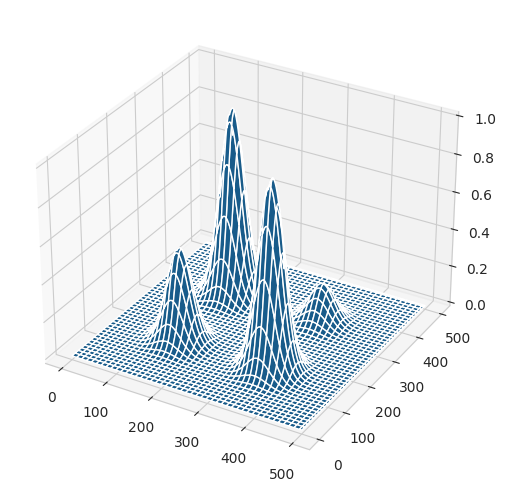

In [56]:
with torch.device("cuda"):
    space = torch.linspace(0, 1, steps=resolution)
    space_2d = torch.cartesian_prod(space, space)
    test_loc = torch.tensor(
        [[0.3, 0.3], [0.7, 0.3], [0.3, 0.7], [0.7, 0.7]], dtype=torch.float32
    ).unsqueeze(1)
    test_cov = 1e-2 * torch.eye(2).reshape(1, 2, 2).broadcast_to(len(test_loc), 2, 2)
    data_peaked = (
        torch.einsum(
            "cbx,cxX,cbX->cb",
            space_2d - test_loc,
            torch.inverse(test_cov),
            space_2d - test_loc,
        )
        .reshape(1, -1, resolution, resolution)
        .mul(-2)
        .exp()
        .mul(torch.tensor([0.5, 1, 1, 0.2], dtype=torch.float32).view(1, -1, 1, 1))
        .sum(1, keepdim=True)
    )
    # data_peaked += torch.randn_like(data_peaked) * 0.01
plot_3d(data_peaked)

In [8]:
class Adjunction(typing.NamedTuple):
    dilation: Callable
    erosion: Callable
    name: str

In [9]:
INF = float("inf")
flat_kernels = torch.full((5, 1, kernel_size, kernel_size), -INF, device='cuda')
width = 5
klow = kernel_size // 2 - width
khi = kernel_size // 2 + width
flat_kernels[:, :, klow:khi, klow:khi] = 0
flat_kernels[[1, 3], :, klow:khi, :] = 0
flat_kernels[[2, 3], :, :, klow:khi] = 0
flat_kernels[4] = 0
flat_kernels.shape

torch.Size([5, 1, 501, 501])

In [10]:
def plot_kernels(kernel: torch.Tensor):
    assert len(kernel.shape) == 4
    kernel = kernel.numpy(force=True)[:, 0]
    _, axs = plt.subplots(ncols=len(kernel), layout="compressed", figsize=(10, 10))
    for k, ax in zip(kernel, axs):
        ax.matshow(k, vmin=-1, vmax=0)

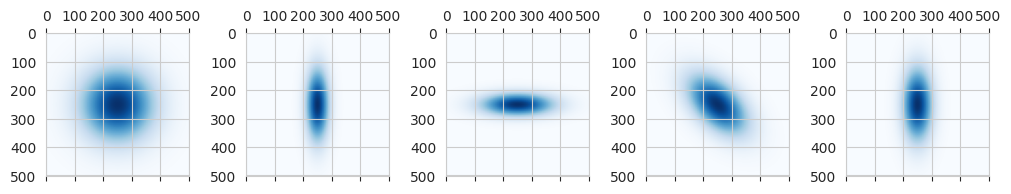

In [32]:
with torch.device("cuda"):
    assert kernel_size % 2
    space = torch.linspace(0, 1, steps=kernel_size)
    space_2d = torch.cartesian_prod(space, space)
    space_2d -= space_2d[kernel_size * kernel_size // 2].clone()
    test_cov = 0.4 * torch.tensor([
        [[0.3, 0], [0, 0.3]],
        [[0.3, 0], [0, 0.03]],
        [[0.03, 0], [0, 0.3]],
        [[0.2, 0.1], [0.1, 0.2]],
        [[0.3, 0], [0, 0.05]],
    ], dtype=torch.float32)
    rounded_kernels = (
        torch.einsum(
            "bx,cxX,bX->cb",
            space_2d,
            torch.inverse(test_cov),
            space_2d,
        )
        .reshape(-1, 1, kernel_size, kernel_size)
        .mul(-2)
        .exp()
    )

    # rounded_kernels[-1] += -1.1
    # tri_size = 70
    # for size in range(tri_size, 0, -1):
    #     tri_idx = torch.tril_indices(size, size)
    #     rounded_kernels[-1, :, tri_idx[0] + kernel_size // 2, kernel_size // 2 + tri_idx[1]] = -size / tri_size
    #     rounded_kernels[-1, :, tri_idx[0] + kernel_size // 2, kernel_size // 2 - tri_idx[1]] = -size / tri_size

    rounded_kernels -= rounded_kernels.view(-1, kernel_size * kernel_size).max(1).values.view(-1, 1, 1, 1)
    # rounded_kernels[rounded_kernels <= -0.97] = -1
    # rounded_kernels[rounded_kernels > -0.05] = 0

plot_kernels(rounded_kernels)

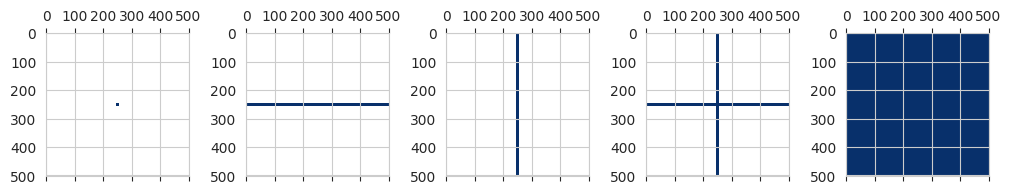

In [12]:
plot_kernels(flat_kernels)

In [13]:
ss_adj = Adjunction(
    SelectSemifield.tropical_max().module(2),
    SelectSemifield.tropical_min().module(2),
    "Select"
)
tr_adj = Adjunction(
    TropicalConv2D(is_max=True),
    TropicalConv2D(is_max=False),
    "Old"
)
un_adj = Adjunction(
    BroadcastSemifield.tropical_max().module(),
    BroadcastSemifield.tropical_min().module(),
    "Unfold"
)

In [14]:
def plot_2d(data: torch.Tensor, batch: int = 0, channel: int = 0, ax=None, title: str = "", vmin=0, vmax=1,
            imshow: bool = False):
    assert len(data.shape) == 4
    data = data[batch, channel].numpy(force=True)
    if ax is None:
        _, ax = plt.subplots(layout="compressed")
    if imshow:
        ax.imshow(data, vmin=vmin, vmax=vmax)
        ax.axis("off")
    else:
        ax.matshow(data, vmin=vmin, vmax=vmax)
    ax.set_title(title)

In [53]:
def plot_adjunction(data: torch.Tensor, adj: Adjunction, kernel: torch.Tensor, suptitle: str = "", surface: bool = True,
                    **conv_kwargs):
    if surface:
        plot_fn = plot_3d
    else:
        plot_fn = plot_2d
    fig, axss = plt.subplots(nrows=2, ncols=3, subplot_kw={"projection": "3d"} if surface else {}, layout="compressed",
                             figsize=(10, 10))
    plot_fn(data, ax=axss[0, 0], title="Original: $f$", imshow=False)
    plot_fn(kernel.movedim(0, 1), ax=axss[1, 0], title="Kernel: $g$", vmin=-1, vmax=0)

    eroded = adj.erosion(data, kernel, **conv_kwargs)
    opened = adj.dilation(eroded, kernel, **conv_kwargs)

    dilated = adj.dilation(data, kernel, **conv_kwargs)
    closed = adj.erosion(dilated, kernel, **conv_kwargs)

    plot_fn(eroded, ax=axss[0, 1], title=r"Eroded: $f \boxminus g$", imshow=True)
    plot_fn(opened, ax=axss[0, 2], title=r"Opened: $(f \boxminus g) \boxplus g$", imshow=True)

    plot_fn(dilated, ax=axss[1, 1], title=r"Dilated: $f \boxplus g$", imshow=True)
    plot_fn(closed, ax=axss[1, 2], title=r"Closed: $(f \boxplus g) \boxminus g$", imshow=True)

    permissible_error = 0.00005
    dilation_err = data - dilated
    erosion_err = eroded - data
    opened_err = opened - data
    closed_err = data - closed

    for errs, name in zip((dilation_err, erosion_err, opened_err, closed_err),
                          ("Dilation", "Erosion", "Opening", "Closing")):
        if (errs > permissible_error).any():
            plot_fn(errs, title=f"{suptitle + ": " if suptitle else ""}errors in {name}")

    fig.suptitle(suptitle)
    fig.show()

    # assert (dilation_err < permissible_error).all(), f"{suptitle}: Dilation should always be >="
    # assert (erosion_err < permissible_error).all(), f"{suptitle}: Erosion should always be <="
    # assert (closed_err < permissible_error).all(), f"{suptitle}: Closing should always be <=, {closed_err.max()=}"
    # assert (opened_err < permissible_error).all(), f"{suptitle}: Opening should always be >=, {opened_err.max()=}"



In [29]:
# img (500x500) (+) kernel (501x501) ~ 110ms, 7000 loops
# %timeit ss_adj.erosion(data_peaked, rounded_kernels[3:4], padding=kernel_size // 2)

In [16]:
run_timings = False
if run_timings:
    %timeit ss_adj.erosion(data_peaked, rounded_kernels[3:4], padding=kernel_size // 2)
    %timeit un_adj.erosion(data_peaked, rounded_kernels[3:4], padding=kernel_size // 2)
    %timeit tr_adj.erosion(data_peaked, rounded_kernels[3:4], padding=kernel_size // 2)

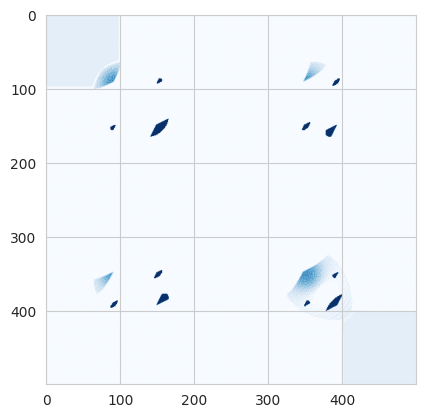

In [27]:
dg = (data_peaked + torch.randn_like(data_peaked) * 1e-5).requires_grad_(True)
ss_adj.dilation(dg, rounded_kernels[3:4], padding=kernel_size // 2).sum().backward()
plt.imshow(dg.grad.numpy(force=True)[0, 0], vmin=0, vmax=10)

<Figure size 640x480 with 0 Axes>

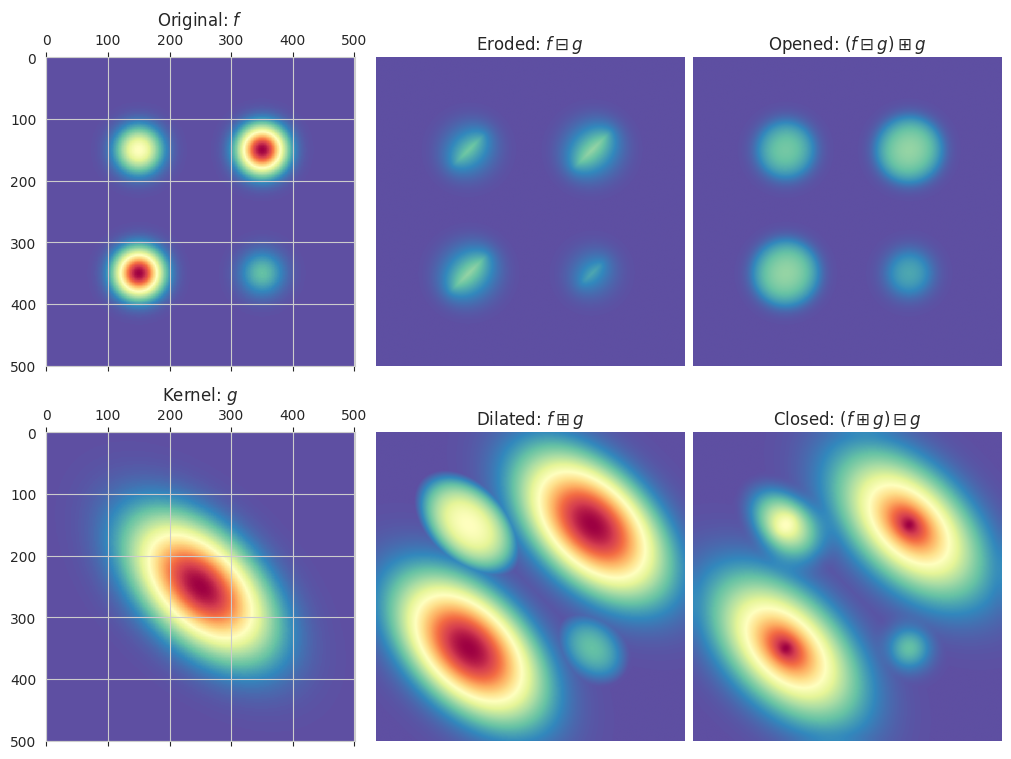

In [58]:

plt.set_cmap("Spectral_r")
plot_adjunction(data_peaked, ss_adj,
                rounded_kernels[3:4], padding=kernel_size // 2,
                surface=False)

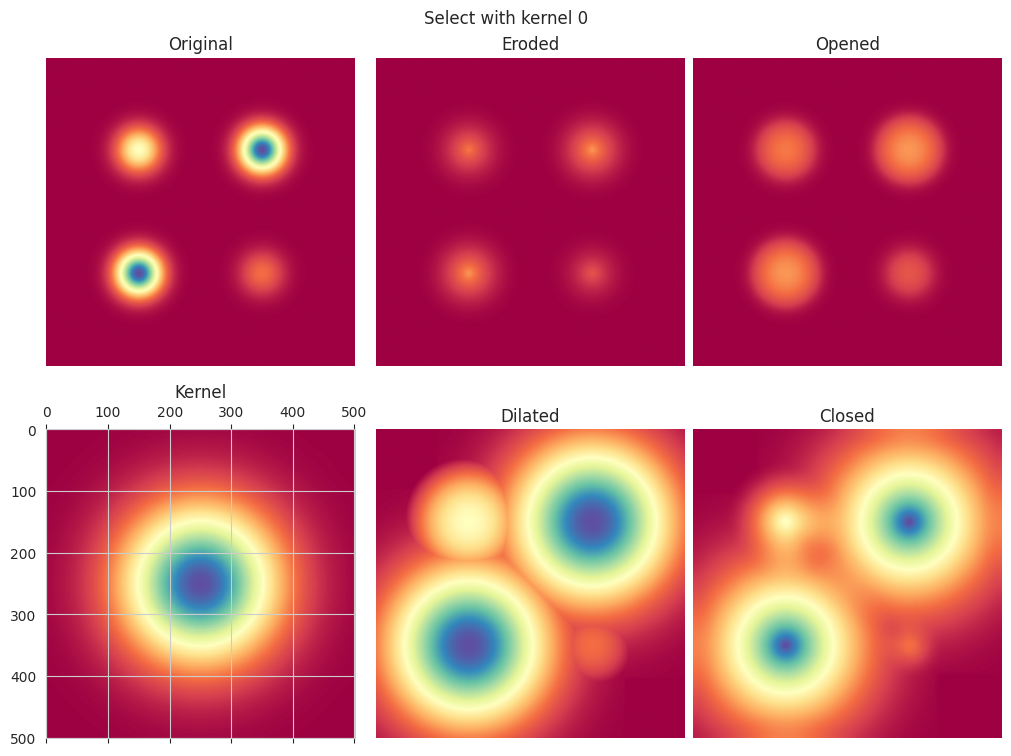

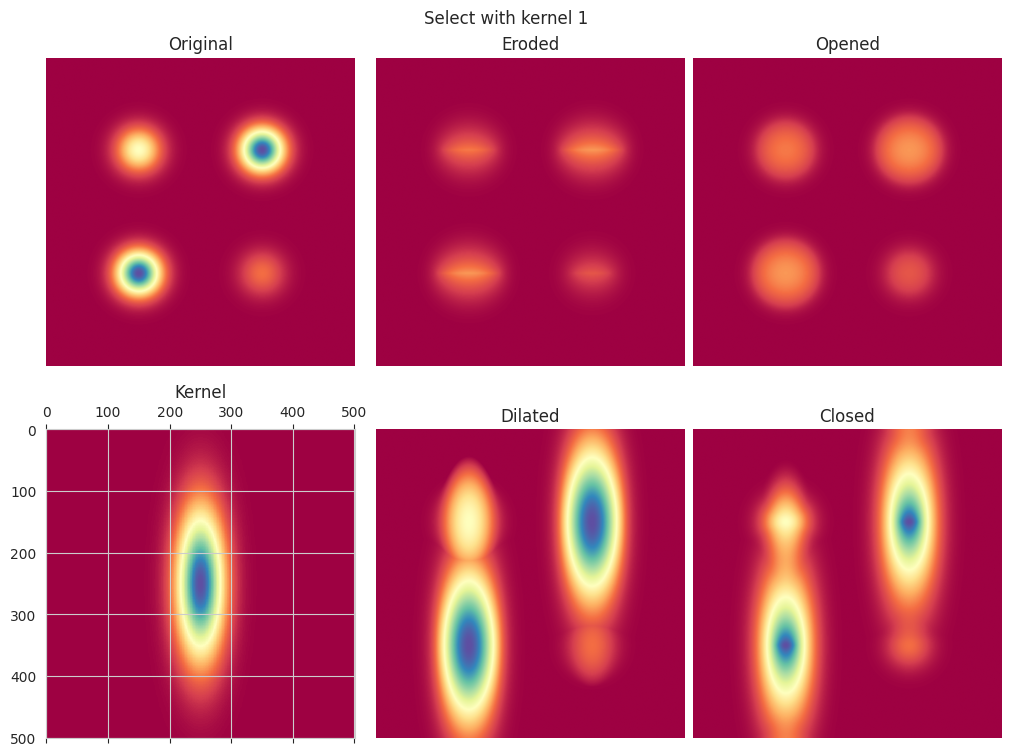

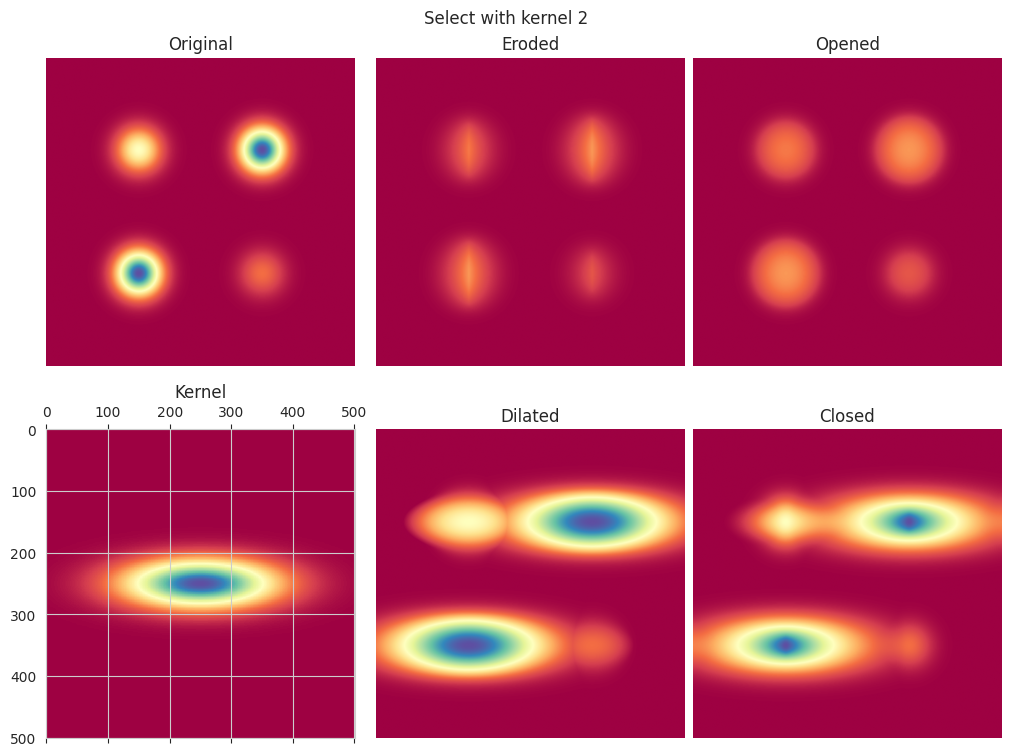

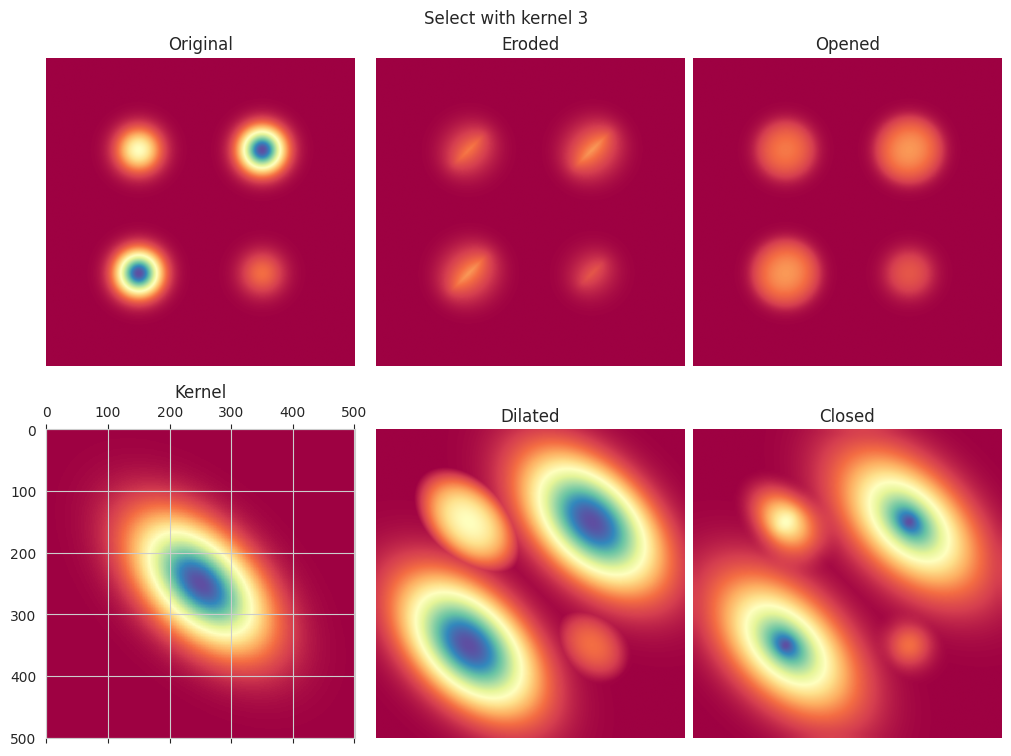

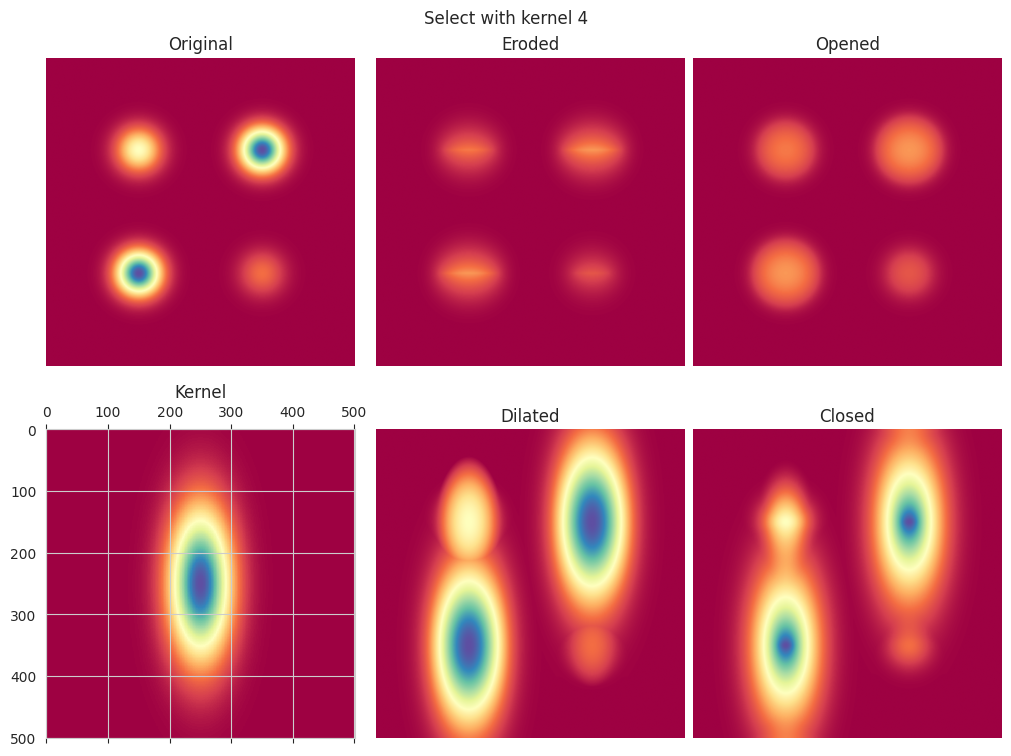

In [43]:
from itertools import product


def check_all(data, kernel, run_all: bool = False):
    adjs = (ss_adj, tr_adj, un_adj) if run_all else (ss_adj,)
    for adj, (k_nr, kernel) in product(adjs, enumerate(kernel)):
        plot_adjunction(data, adj, kernel.unsqueeze(0), suptitle=f"{adj.name} with kernel {k_nr}",
                        padding=kernel_size // 2, surface=False)


check_all(data_peaked, rounded_kernels)